# Digit Recognizer

First, we'll read in our training data

In [33]:
import pandas as pd
import numpy as np

data = pd.read_csv("train.csv")
labels = data["label"]

data = data.drop("label", axis=1)
data = data.to_numpy(dtype=int)

n_pixels = data.shape[1]
n_points = data.shape[0]

Let's get the dimensions of our data and then turn them into tensors

In [34]:
from torch import cuda
from torch import Tensor, FloatTensor, IntTensor

device = "cuda" if cuda.is_available() else "cpu"

l = int(sqrt(n_pixels))
image_tensor = FloatTensor(data).reshape([n_points, 1, l, l]).to(device)
labels_tensor = IntTensor(labels).reshape([n_points]).to(device)

Now, we'll define our NN

In [35]:
from torch.nn import *
from torch.optim import Adam, Optimizer
from math import sqrt, ceil
from torch import zeros

class DigitRecognizer(Module):
    """Class for neural network on MNIST dataset
    
    Takes in optimizer class and loss_function as parameters, and keyword args apply to the optimizer
    """

    def __init__(self, optimizer: Optimizer = Adam, loss_func: modules.loss._Loss = CrossEntropyLoss(), **kwargs):
        super().__init__()
        self.layers = Sequential(
            Conv2d(in_channels=1, out_channels=1, kernel_size=2),
            Flatten(),
            Linear(in_features=729, out_features=100),
            ReLU(),
            Linear(in_features=100, out_features=100),
            ReLU(),
            Linear(100, 50),
            ReLU(),
            Linear(50, 10)
        )

        self.loss_func: modules.loss._Loss = loss_func
        self.optimizer: Optimizer          = optimizer(params = self.parameters(), **kwargs)

    def forward(self, x):
        return self.layers(x)
    
    def fit(self, X, y, epochs: int = 1000, batch_size: int = 1, wait: bool = False, print_intervals = 1000):
        """Fits the digit recognizer to X (of shape [n_samples, 1, width, height])"""

        n_samples = X.shape[0]

        losses = []
        for t in range(epochs):
            self.optimizer.zero_grad()

            sum_batch_error = 0
            for b in range(0, ceil(n_samples / batch_size)):
                # get batch of batch_size, or smaller if at the end of the training data
                batch = X[b * batch_size : \
                          min(n_samples, (b + 1) * batch_size)]
                labels = y[b * batch_size : \
                          min(n_samples, (b + 1) * batch_size)]
                
                curr_size = labels.shape[0]

                # make target label vector
                labels_dummies = zeros(curr_size, 10).to(device=device)
                for i in range(curr_size): labels_dummies[i, labels[i]] = 1
                
                forward = self.forward(batch)
                
                loss = self.loss_func(input = forward, target = labels_dummies)

                sum_batch_error += loss.sum()

                loss.backward()

                if not wait:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                
                if (b+1) % print_intervals == 0:
                    ave = sum_batch_error / (batch_size * print_intervals)
                    print(f"Loss at {t+1:<2}.{b+1:<10}: {ave}")

                    losses.append(ave)
                    sum_batch_error = 0
            
            if wait:
                self.optimizer.step()
                self.optimizer.zero_grad()
        
        return losses

Train it...

In [36]:
batch_size = 5
epochs = 10
print_interval = 1000

model = DigitRecognizer().to(device=device)
losses = model.fit(image_tensor, labels_tensor, epochs=epochs, batch_size=batch_size, print_intervals=print_interval)

Loss at 1 .1000      : 0.11900069564580917
Loss at 1 .2000      : 0.07129210233688354
Loss at 1 .3000      : 0.06065277010202408
Loss at 1 .4000      : 0.053688663989305496
Loss at 1 .5000      : 0.049616359174251556
Loss at 1 .6000      : 0.050248220562934875
Loss at 1 .7000      : 0.04382048919796944
Loss at 1 .8000      : 0.039389707148075104
Loss at 2 .1000      : 0.03762508183717728
Loss at 2 .2000      : 0.037845008075237274
Loss at 2 .3000      : 0.03627718612551689
Loss at 2 .4000      : 0.03424175828695297
Loss at 2 .5000      : 0.03367184102535248
Loss at 2 .6000      : 0.03283407539129257
Loss at 2 .7000      : 0.02682887762784958
Loss at 2 .8000      : 0.029174761846661568
Loss at 3 .1000      : 0.02591365948319435
Loss at 3 .2000      : 0.029946450144052505
Loss at 3 .3000      : 0.026310943067073822
Loss at 3 .4000      : 0.025343623012304306
Loss at 3 .5000      : 0.02653815783560276
Loss at 3 .6000      : 0.026577383279800415
Loss at 3 .7000      : 0.022034883499145508


Let's see the overall accuracy on the data...

In [37]:
from torch import argmax
outputs = Softmax()(model.forward(image_tensor))
acc = ((argmax(outputs, dim=1) == labels_tensor).sum() / n_points).item()
acc

c:\Users\Tony Zheng\.conda\envs\Competitions\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.982952356338501

And let's see how loss changed over time...

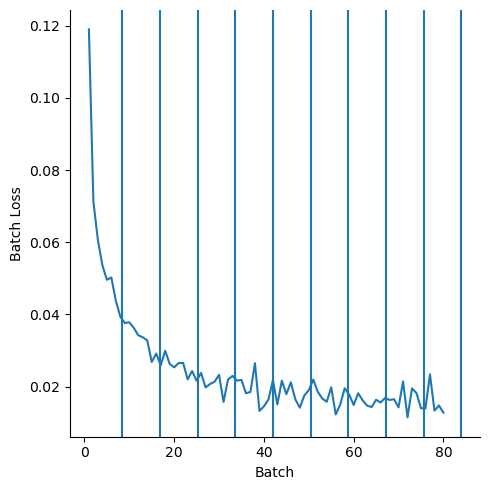

In [38]:
import seaborn as sns

non_tensor_losses = [0] * len(losses)
for i in range(len(losses)): non_tensor_losses[i] = losses[i].item()

data = pd.DataFrame(data=non_tensor_losses, columns=["Batch Loss"])
data["Batch"] = [i + 1 for i in range(data.shape[0])]

grid = sns.relplot(data=data, x='Batch', y='Batch Loss', kind="line")
for ax in grid.axes.flat:
    for i in range(epochs):
        ax.axvline(x = (i + 1) * n_points / (batch_size * print_interval))

In [39]:
test_data = pd.read_csv("test.csv")
test_n_points = test_data.shape[0]
test_image_tensor = FloatTensor(test_data.to_numpy(dtype=int)).reshape([test_n_points, 1, l, l]).to(device)

test_outputs = Softmax()(model.forward(test_image_tensor))
out_labels = argmax(test_outputs, dim=1)
out_labels

c:\Users\Tony Zheng\.conda\envs\Competitions\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([2, 0, 9,  ..., 3, 9, 2], device='cuda:0')

In [40]:
df = pd.DataFrame(out_labels.cpu().numpy())
df.index += 1
df.to_csv("submission.csv", index_label="ImageId", header=["Label"])